In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Load the Data

The data in this lab is taken from one of the sample datasets in the [MNE website](https://martinos.org/mne/stable/index.html). The sample data is a recording from one subject who experienced some auditory stimulus on the left ear.    

The raw data is very large (`1.5G`) and also requires that you install the `mne` python package. To make this lab easier, I have extracted and processed a small section of the data. The following command will download a `pickle` file `eeg_dat.p` to your local machine.  If you do want to create the data yourself, the program to create the data is in this directory in the github repository.

In [2]:
fn_src ='https://drive.google.com/uc?export=download&id=1RzQpKONOcXSMxH2ZzOI4iVMiTgD6ttSl'
fn_dst ='eeg_dat.p'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    print('Fetching file %s [53MB].  This may take a minute..' % fn_dst)
    urllib.request.urlretrieve(fn_src, fn_dst)
    print('File %s downloaded' % fn_dst)

File eeg_dat.p is already downloaded


Now run the following command which will get the data from the `pickle` file.

In [3]:
import pickle
fn = 'eeg_dat.p'
with open(fn, 'rb') as fp:
    [X,Y] = pickle.load(fp)

To understand the data, there are three key variables:
* `nt`    = number of time steps that we measure data
* `nchan` = number of channels (i.e. electrodes) measured in each time step
* `ncur`  = number of currents in the brain that we want to estimate.  

Each current comes from one brain region (called a *voxel*) in either the `x`, `y` or `z` direction.  So,

    nvoxels = ncur / 3
    
The components of the `X` and `Y` matrices are:
*  `Y[i,k]` = electric field measurement on channel `i` at time `k`
*  `X[i,j]` = sensitivity of channel `i` to current `j`.

Using `X.shape` and `Y.shape` compute and print `nt`, `nchan`, `ncur` and `nvoxels`.

In [4]:
# TODO
# nt = ...
nt=Y.shape[1]
# ncur = ...
ncur=X.shape[1]
# nchan = ...
nchan=Y.shape[0]
# nvoxels
nvoxels=ncur/3

## Ridge Regression

Our goal is to estimate the currents in the brain from the measurements `Y`.  One simple linear model is:

    Y[i,k]  = \sum_j X[i,j]*W[j,k]+ b[k]

where `W[j,k]` is the value of current `j` at time `k` and `b[k]` is a bias.  We can solve for the current matrix `W` via linear regression.  

Howeever, there is a problem:
*  There are `nt x ncur` unknowns in `W`
*  There are only `nt x nchan` measurements in `Y`.

In this problem, we have:

    number of measurements  << number of unknowns
    
We need to use regularization in these circumstances.  We first try Ridge regression.

First split the data into training and test.  Use the `train_test_split` function with `test_size=0.33`.

In [5]:
# TODO
Xtr,Xts,Ytr,Yts = train_test_split(X,Y,test_size=0.33) 

Use the `Ridge` regression object in `sklearn` to fit the model on the training data.  Use a regularization, `alpha=1`.

In [6]:
# TODO
# regr = Ridge(...)
regr=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Preict the values `Y` on both the training and test data.  Use the `r2_score` method to measure the `R^2` value on both the training and test.  You will see that `R^2` value is large for the training data, it is very low for the test data.  This suggest that even with regularization, the model is over-fitting the data.

In [7]:
# TODO
regr.fit(Xtr,Ytr)
y_tr_pred=regr.predict(Xtr)
rsq_tr=r2_score(Ytr,y_tr_pred);
print(rsq_tr)
# rsq_ts = ...
y_ts_pred=regr.predict(Xts)
rsq_ts=r2_score(Yts,y_ts_pred);
print(rsq_ts)

0.5841787010190982
0.17933554891324263


Next, try to see if we can get a better `R^2` score using different values of `alpha`.  Use cross-validation to measure the test `R^2` for 20 `alpha` values logarithmically spaced from `10^{-2}` to `10^{2}` (use `np.logspace()`).  You can use regular cross-validation.  You do not need to do `K`-fold.

In [8]:
# TODO
#print(np.logspace(10**-2,10**2))
# TODO
alphas = np.logspace(-2,2,20)

r2test = []
r2tr = []
for i in alphas:
    regr = Ridge(i,copy_X=True,fit_intercept = True,max_iter = None, 
             normalize = False, random_state = None, solver = 'auto', tol = 0.001)
    regr.fit(Xtr,Ytr)
    y_tr_pred = regr.predict(Xtr)
    rsq_tr = r2_score(Ytr,y_tr_pred)
    r2tr.append(rsq_tr)

    y_ts_pred = regr.predict(Xts)
    rsq_ts = r2_score(Yts,y_ts_pred)
    r2test.append(rsq_ts)

Plot the test `R^2` vs. `alpha`.  And print the maximum test `R^2`.  You should see that the maximum test `R^2` is still not very high.

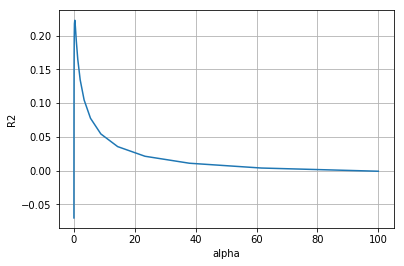

In [9]:
# TODO
plt.plot(alphas,r2test)
plt.xlabel("alpha")
plt.ylabel("R2")
plt.grid()
plt.show()

Now, let's take a look at the solution. 

* Find the optimal regularization `alpha` from the cross-validation
* Re-fit the model at the optimal `alpha`
* Get the current matrix `W` from the coefficients in the linear model.  These are stored in `regr.coef_`.  You may need a transpose
* For each current `j` compute `Wrms[j] =  sqrt( sum_k W[j,k]**2 )` which is root mean squared current.

You will see that the vector `Wrms` is not sparse.  This means that the solution that is found with Ridge regression finds currents in all locations.

[1.443523640787805, 1.4767647594223297, 1.4948707092600704, 1.50151587170636, 1.5021963481200282, 1.502231408649967, 1.5051890549695772, 1.5124729211989005, 1.5241789268756356, 1.54054095529104, 1.5629306222736672, 1.5937214069888783, 1.6350684186863083, 1.6873590796050484, 1.7483787731421976, 1.8137181660913497, 1.878166977493516, 1.937362677134011, 1.9890298479154183, 2.033545925618452, 2.073858912481044, 2.114907115621299, 2.162702153767039, 2.2231178195767822, 2.300528195659221, 2.396487748897738, 2.508896380035613, 2.6320302042785784, 2.757501948297524, 2.8758893784467308, 2.978559106389872, 3.059196996936037, 3.1147011736947263, 3.145236143799624, 3.1534804830607595, 3.143286715053148, 3.118235774672245, 3.0806079712780945, 3.031165804110422, 2.969766373427832, 2.896446227853333, 2.8123982398257024, 2.720401688015803, 2.624529116098384, 2.529343395925048, 2.439023854209642, 2.3568394649991924, 2.2851460204194645, 2.2256772514602217, 2.17966166510716, 2.1474548364193313, 2.1278141

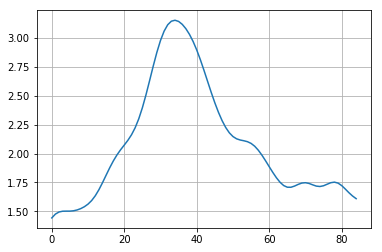

In [11]:
# TODO
#im=np.argmax(rsq)
#aopt=alphas[im]

opAlpha = alphas[r2test.index(max(r2test))]
regr = Ridge(opAlpha,copy_X=True,fit_intercept = True,max_iter = None, 
             normalize = False, random_state = None, solver = 'auto', tol = 0.001)
regr.fit(Xtr,Ytr)
w = regr.coef_
w.transpose()

Wrms = []

for i in w:
    rms = (np.sum(i**2))**0.5
    Wrms.append(rms)
print(Wrms)
print(w)
#plt.plot(Wrms)
#plt.grid()

## LASSO Regression

We can improve the estimate by imposing sparsity.  Biologically, we know that only a limited number of brain regions should be involved in the reponse to a particular stimuli.  As a result, we would expect that the current matrix `W[j,k]` to be zero for most values `j,k`.  We can impose this constraint using LASSO regularization.

Re-fit the training data using the `Lasso` model with `alpha=1e-3`.  Also set `max_iter=100` and `tol=0.01`.  The LASSO solver is much slower, so this make take a minute.

In [11]:
# TODO
model = Lasso(alpha=1e-3,max_iter=100,tol=0.01)
model.fit(Xtr,Ytr)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.01, warm_start=False)

Now, test the model on the test data and measure the `R^2` value.  You should get a much better fit than with the Ridge regression solution.  

In [12]:
# TODO
y_ts_pred=model.predict(Xts)
rsq_ts=r2_score(Yts,y_ts_pred);
print(rsq_ts)

0.1769081278984139


We can now search for the optimal `alpha`.  Use cross-validation to find the `alpha` logarithically space between `alpha=10^{-3}` and `alpha=10^{-4}`.  Each fit takes some time, so use only 5 values of `alpha`. Also for each `alpha` store the current matrix.  This way, you will not have to re-fit the model.

In [13]:
# TODO
alphas = np.logspace(-2,2,5)

r2test = []
r2tr = []
for i in alphas:
    regr = Ridge(i,copy_X=True,fit_intercept = True,max_iter = None, 
             normalize = False, random_state = None, solver = 'auto', tol = 0.001)
    regr.fit(Xtr,Ytr)
    y_tr_pred = regr.predict(Xtr)
    rsq_tr = r2_score(Ytr,y_tr_pred)
    r2tr.append(rsq_tr)

    y_ts_pred = regr.predict(Xts)
    rsq_ts = r2_score(Yts,y_ts_pred)
    r2test.append(rsq_ts)
    
opAlpha = alphas[r2test.index(max(r2test))]
regr = Ridge(opAlpha,copy_X=True,fit_intercept = True,max_iter = None, 
             normalize = False, random_state = None, solver = 'auto', tol = 0.001)
regr.fit(Xtr,Ytr)
w = regr.coef_
w.transpose()

Wrms = []

for i in w:
    rms = (np.sum(i**2))**0.5
    Wrms.append(rms)
print(Wrms)
print(w)

[0.8063988417375824, 0.8231380074672502, 0.8322246418529665, 0.8379415976107462, 0.8463043529379282, 0.8631146057765581, 0.892025310914833, 0.9335825600038448, 0.9857221728177794, 1.0451659269079079, 1.1087441506914788, 1.1740920800818897, 1.2397363798657675, 1.30486918332179, 1.3691057866380218, 1.4323613582275343, 1.4948570007431499, 1.5571657809967157, 1.6201991790984234, 1.685097895250554, 1.7530361753005534, 1.8249847692770031, 1.9014638015968421, 1.9823014096653058, 2.0664134022376426, 2.1516479668168027, 2.2347792831869673, 2.31173372527834, 2.378065351901633, 2.4296297724381906, 2.4633008734028135, 2.4775653770337587, 2.4728136107326812, 2.451222566097358, 2.416230927177087, 2.3717125813565434, 2.3211036149719333, 2.266768063500689, 2.2098220840486515, 2.1504562626193264, 2.0885631543677157, 2.024346330885091, 1.9586336978148235, 1.8927689069112985, 1.8281794540060865, 1.7658675547756, 1.7061019942947186, 1.6484785333170815, 1.59230096003909, 1.537060405136962, 1.48275417242890

Plot the `r^2` value vs. `alpha`.  Print the optimal `r^2`.  You should see it is much higher than with the best Ridge Regression case.

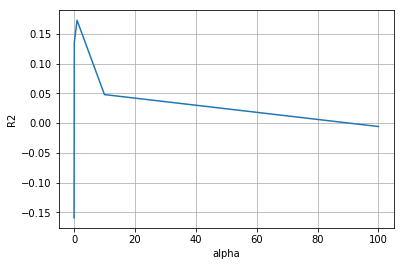

In [14]:
# TODO
plt.plot(alphas,r2test)
plt.xlabel("alpha")
plt.ylabel("R2")
plt.grid()
plt.show()

Display the current matrix `W` for the optimal `alpha` as you did in the Ridge Regression case.  You will see that is much sparser.

In [15]:
# TODO
print(Wrms)
print(w)

[0.8063988417375824, 0.8231380074672502, 0.8322246418529665, 0.8379415976107462, 0.8463043529379282, 0.8631146057765581, 0.892025310914833, 0.9335825600038448, 0.9857221728177794, 1.0451659269079079, 1.1087441506914788, 1.1740920800818897, 1.2397363798657675, 1.30486918332179, 1.3691057866380218, 1.4323613582275343, 1.4948570007431499, 1.5571657809967157, 1.6201991790984234, 1.685097895250554, 1.7530361753005534, 1.8249847692770031, 1.9014638015968421, 1.9823014096653058, 2.0664134022376426, 2.1516479668168027, 2.2347792831869673, 2.31173372527834, 2.378065351901633, 2.4296297724381906, 2.4633008734028135, 2.4775653770337587, 2.4728136107326812, 2.451222566097358, 2.416230927177087, 2.3717125813565434, 2.3211036149719333, 2.266768063500689, 2.2098220840486515, 2.1504562626193264, 2.0885631543677157, 2.024346330885091, 1.9586336978148235, 1.8927689069112985, 1.8281794540060865, 1.7658675547756, 1.7061019942947186, 1.6484785333170815, 1.59230096003909, 1.537060405136962, 1.48275417242890

## More fun

If you want to more on this lab:
* Install the [MNE python package](https://martinos.org/mne/stable/index.html).  This is an amazing package with many tools for processing EEG data.
* In particular, you can use the above results to visualize where in the brain the currents sources are.
* You can also improve the fitting with more regularization.  For example, we know that the currents will be non-zero in groups:  If the current is non-zero for one time, it is likely to non-zero for all time.  You can use the Group LASSO method.
* You can combine these results to make predictions about what the patient is seeing or hearing or thinking.